# HW 4 - Levi Schult 
* notebook with image processing

In [1]:
# import block
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
from astropy.visualization import hist
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
from astropy.nddata import CCDData
phot_tutorial_dir = '/Users/levischult/Desktop/classes/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [2]:
# setting data directory
data_dir = '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/imagedataset/'
reduced_dir = '/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/'

* displaying log file in notebook for future reference!

In [3]:
! cat /Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/imagedataset/log.txt

2009 June 22 local (23rd UT)
Observer: Kobulnicky, J. Runnoe, J. Dornfeld
Clearish, 55F, Humidity 56%
Winds 020 @ 10 mph
Image	Object		exp	Filt	UT	Notes
a005-10	SkyFlats	1	Halpha	
11-14			2	Halpha
15-20			3	Halpha
21			3	U		saturated
22			3	U
23-28			3	U		
29			3	B		     saturated
30			3	B		     saturated
31			3	B		     saturated
32			1	B		     30,000 cts
33			2	B		     
34			3	B		     saturated?
35			3	B	3:13	     
36			3	B	
37			3	B		
38			3	B	
39			4	B	previously not tracking; now tracking
40			5	B    
41			6	B
42			6	B	
43			3	V	3:21
44			6	V	
45			12	V
46			12	V
47			20	V
48			20	V
49			20	V
50			15	R
51			20	R
52			25	R
53			30	R
54			40	R
55			50	R
56			50	I   bad
57			50	I
58			80	I
59			120	I
60			120	I
61			200	I
62			200	I
63 bad
64 focus PG1633+099	2	V	focus=0   3.9 pix fwhm
65 focus			V	focus=200 3.4
66 focus			V	focus=400 5.7
67 focus			V	focus=400 again 6.6 worse!
68 focus			V	focus=250  4.4
69				V	focus=100  3.3
70				V	focus=0	   3.7
71				V	focus=-100 3.1
72				V	foc

In [4]:
# basic image plotting function. taken from image_combination notebook

def basicimgplot(array, titl='Title'):
    min_level = array.min()
    max_level = array.max()
    fig = plt.subplots(1,1,figsize=(4,4))
    plt.imshow(array, vmin=min_level, vmax=max_level)
    plt.xticks([])
    plt.yticks([])
    plt.title(titl)
    plt.grid(False)
    plt.show()

In [5]:
def rms(array):
    return np.sqrt(np.mean(array**2))

# 2

### examining images for overscan regions
* Column 51
* Column 2102
* a123.fits below:

![Screenshot 2023-10-23 at 13.34.16.png](<attachment:Screenshot 2023-10-23 at 13.34.16.png>)
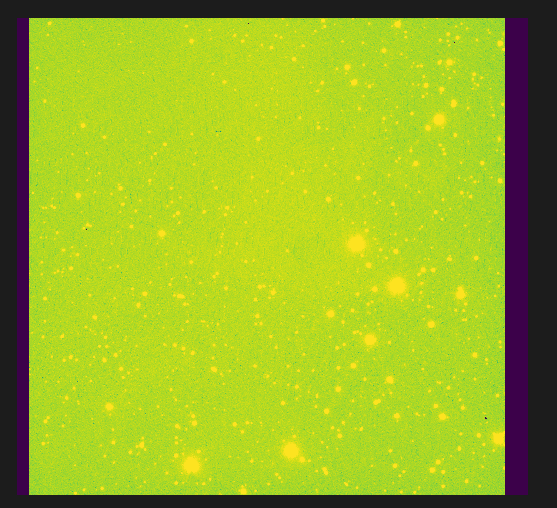

### plotting bias frame!
* a098.fits

![Screenshot 2023-10-23 at 13.42.16.png](<attachment:Screenshot 2023-10-23 at 13.42.16.png>)
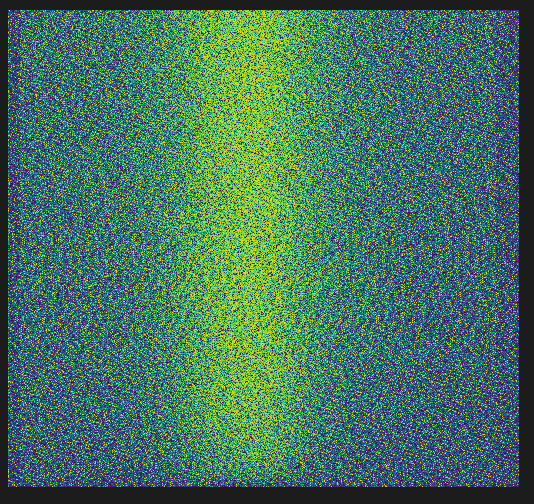

### plotting dark
* d008.fit

![Screenshot 2023-10-23 at 13.44.11.png](<attachment:Screenshot 2023-10-23 at 13.44.11.png>)
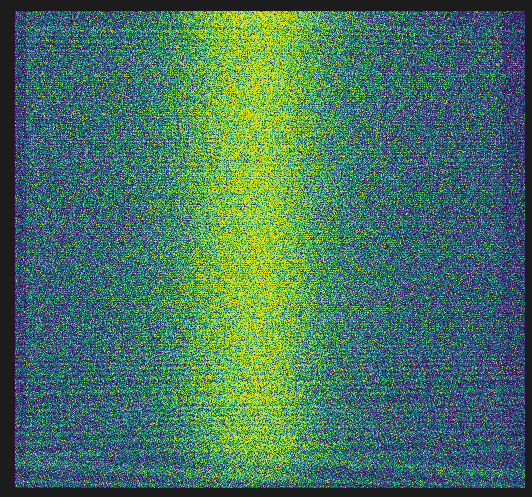

### plotting flat
* a008.fits

![Screenshot 2023-10-23 at 13.46.12.png](<attachment:Screenshot 2023-10-23 at 13.46.12.png>)
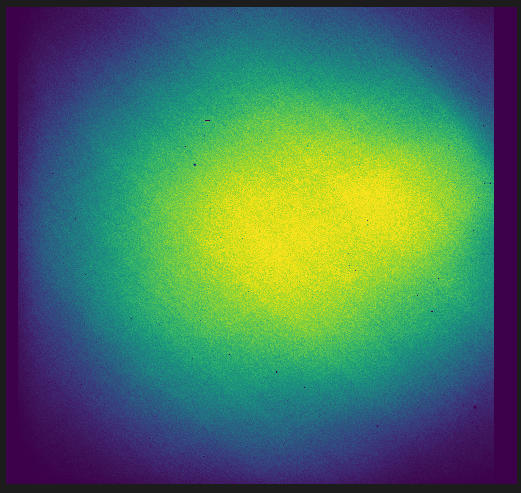

# 3

* plotting lines + columns from bias frame

In [6]:
hdu = fits.open(data_dir+'a098.fits')
hdr = hdu[0].header
img = hdu[0].data

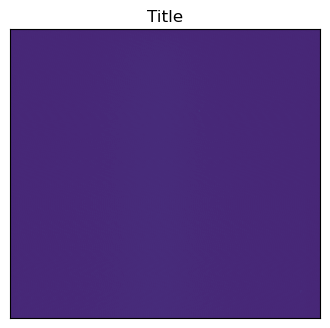

In [7]:
#basicimgplot(img[800:1200, 500:1600])
basicimgplot(img)

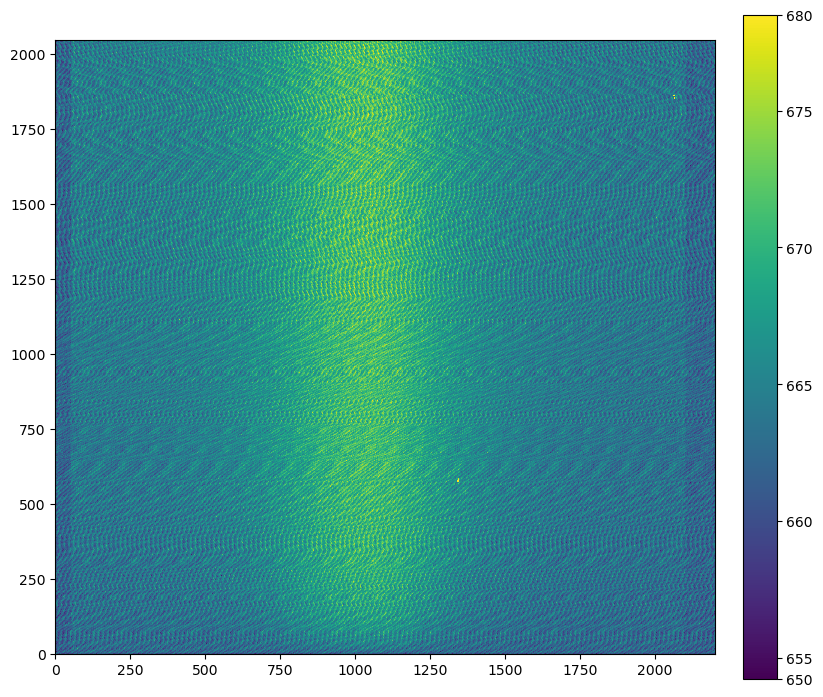

In [8]:
show_image(img)

In [9]:
min_level = array.min()
max_level = array.max()
fig = plt.subplots(1,1,figsize=(4,4))
plt.imshow(array, vmin=min_level, vmax=max_level)
plt.xticks([])
plt.yticks([])
plt.title(titl)
plt.grid(False)
plt.show()

NameError: name 'array' is not defined

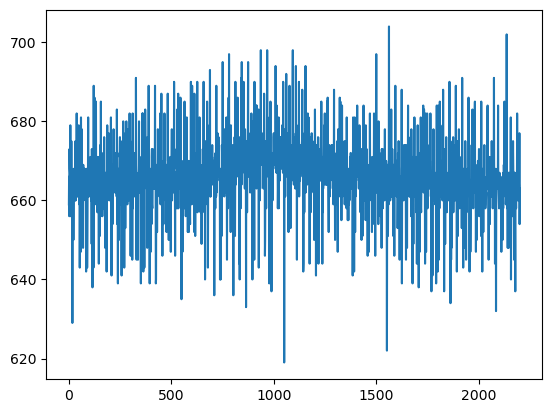

In [ ]:
plt.plot(img[1024,:]) # 1024 row

* mean + rms of entire image

In [ ]:
mean_bias = np.mean(img)
print(mean_bias)

665.6369082919034


In [ ]:
rms_bias = np.sqrt(np.mean(img**2))
print(rms_bias)

212.656196864974


* mean/rms of center of image

In [ ]:
bias_center = img[512:1536, 512:1536]
mean_bias = np.mean(bias_center)
print(mean_bias)

668.0392589569092


In [ ]:
rms_bias = rms(bias_center)
print(rms_bias)

217.0860314370543


# 5
* finding overscan regions in python rather than DS9

In [ ]:
hdu = fits.open(data_dir+'a128.fits')
hdr = hdu[0].header
img = hdu[0].data

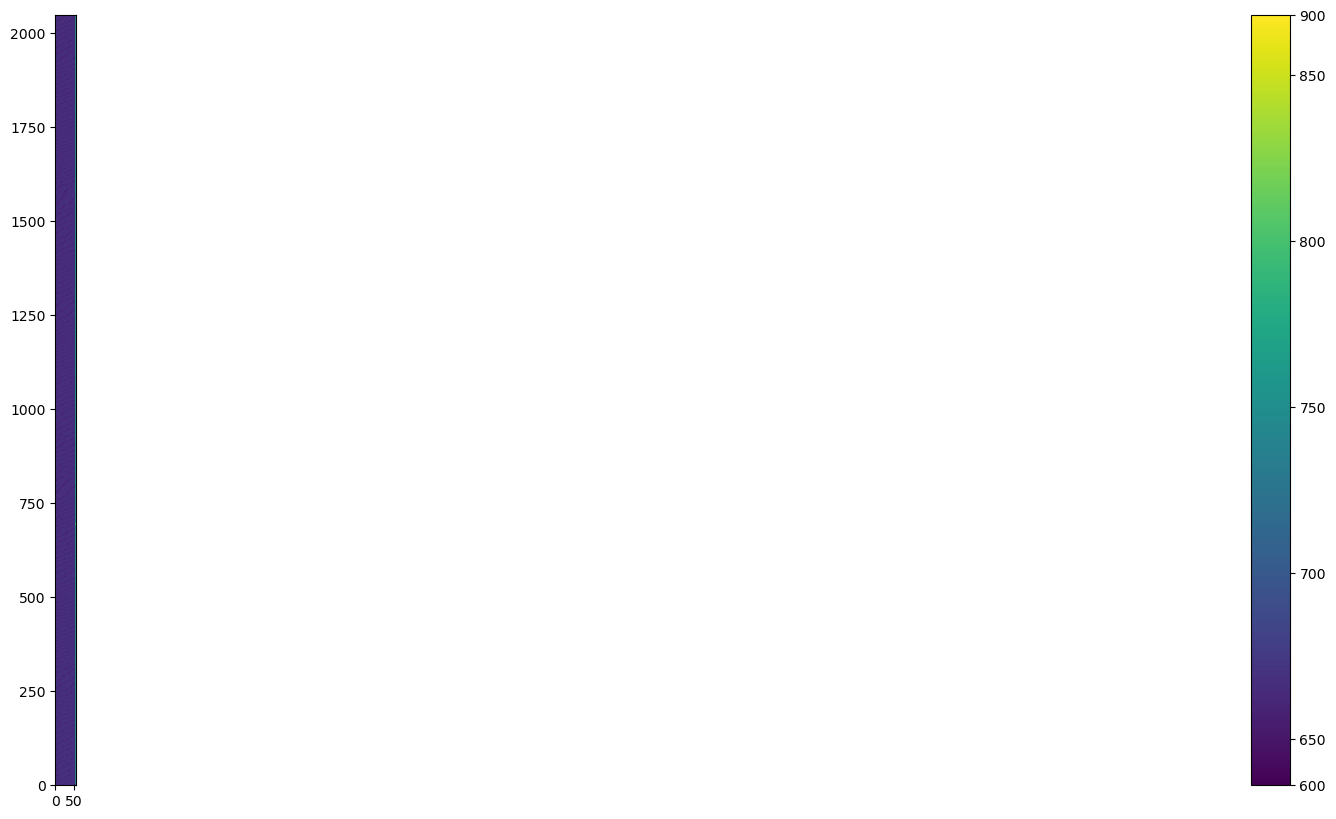

In [ ]:
show_image(img[:, :54])

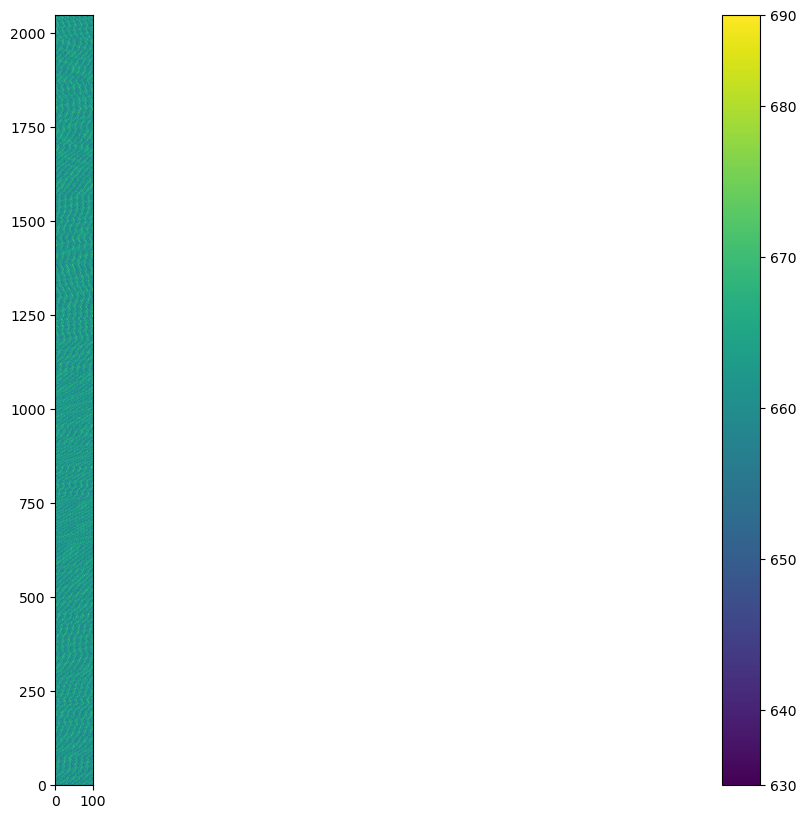

In [10]:
show_image(img[:, 2099:])

* image starts on 55 and ends on 2098

* adding headers to the images: BIASSEC, TRIMSEC, FILTER, and IMAGETYP

In [11]:
TRIMSEC_FITS = '[56:2100, :]'
TRIMSEC_PYTH = '[:, 55:2099]'

BIASSEC_R_FITS = '[2099:, :]'
BIASSEC_R_PYTH = '[:, 2098:]'

BIASSEC_L_FITS = '[:56, :]'
BIASSEC_L_PYTH = '[:, :55]'

In [12]:
# adding headers:





# skyflats
for i in range(5, 11):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'Halpha'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'SkyFlats'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

# science images
for i in range(11, 21):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'Halpha'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'SkyFlats'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(21, 29):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'U'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'SkyFlats'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(29, 43):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'B'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'SkyFlats'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(43, 50):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'V'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'SkyFlats'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(50, 56):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'R'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'SkyFlats'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(56, 63):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'I'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'SkyFlats'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(64, 81):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'V'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(64, 81):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'V'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(81, 83):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'U'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(83, 85):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'B'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(85, 87):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'V'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(87, 89):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'R'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(89, 91):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'I'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(91, 93):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'Halpha'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)


for i in range(93, 112):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'N/A'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'Bias'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(130, 132):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'U'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(132, 134):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'B'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(134, 136):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'V'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)


for i in range(136, 138):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'R'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(138, 140):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'I'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)


for i in range(153, 155):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'I'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'NGC6823'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)


for i in range(155, 157):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'R'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'NGC6823'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)


for i in range(157, 160):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'V'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'NGC6823'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(160, 162):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'B'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'NGC6823'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(162, 164):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'U'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'NGC6823'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(202, 204):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'U'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(204, 206):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'B'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(206, 208):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'V'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)


for i in range(208, 210):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'R'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(210, 212):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'I'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(221, 223):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'U'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(223, 227):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'B'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(227, 231):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'V'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)


for i in range(231, 233):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'R'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(233, 235):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'I'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(235, 237):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'R'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(237, 239):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'U'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(239, 241):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'B'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(241, 243):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'V'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)


for i in range(243, 245):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'R'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(245, 247):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'a' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'I'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'PG1633+099'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)

for i in range(1, 16):
    if len(str(i)) == 1:
        fnum = '00' + str(i)
    if len(str(i)) == 2:
        fnum = '0' + str(i)
    filename = 'd' + fnum + '.fits'
    hdu = fits.open(data_dir + filename)
    hdr = hdu[0].header
    hdr['FILTER'] = 'N/A'
    hdr['TRIMSEC'] = TRIMSEC_FITS
    hdr['IMAGETYP'] = 'Dark'
    hdr['BIASSEC_R'] = BIASSEC_R_FITS # right overscan region
    hdr['BIASSEC_L'] = BIASSEC_L_FITS # left overscan region
    hdu.writeto(reduced_dir + filename, overwrite=True)



In [13]:
imgs = ccdp.ImageFileCollection(reduced_dir, glob_include='*.fits')

In [14]:
biasframes = imgs.files_filtered(imagetyp='Bias', include_path=True)
biasframes[0]

'/Users/levischult/Desktop/classes/astr_8060_f23/work/schultls/misc_works/reduced/a093.fits'

* mean/median for image region of bias frames

In [15]:
biasframes = imgs.files_filtered(imagetyp='Bias')
biasmean = []
biasmedi = []

for file in biasframes:
    hdu = fits.open(reduced_dir+file)
    hdr = hdu[0].header
    img = hdu[0].data
    biasmean.append(np.mean(img[:, 55:2098]))
    biasmedi.append(np.median(img[:, 55:2098]))
    print(f'mean:{np.mean(img[:, 55:2098])}')
    print(f'median:{np.median(img[:, 55:2098])}')

mean:666.0853474038638
median:666.0
mean:665.7560371925478
median:666.0
mean:665.8097407209832
median:666.0
mean:665.9230458711912
median:666.0
mean:665.912636613589
median:666.0
mean:665.8885719721304
median:666.0


* bias overscan regions

In [16]:
biasframes = imgs.files_filtered(imagetyp='Bias')
biasovrsmn = [] # overscan means
biasovrsmd = [] # overscan median

for file in biasframes:
    hdu = fits.open(reduced_dir+file)
    hdr = hdu[0].header
    img = hdu[0].data
    totalovrscn = np.zeros((2048,157))
    totalovrscn[:, :55] = img[:, :55]
    totalovrscn[:, 55:] = img[:, 2098:]
    biasovrsmn.append(np.mean(totalovrscn))
    biasovrsmd.append(np.median(totalovrscn))
    print(f'mean:{np.mean(totalovrscn)}')
    print(f'median:{np.median(totalovrscn)}')

mean:662.5504080414013
median:663.0
mean:662.223623482285
median:662.0
mean:662.2753564142117
median:662.0
mean:662.3959307822453
median:663.0
mean:662.3682231538614
median:663.0
mean:662.3620745421974
median:663.0


* getting mean/median of overscan regions for the rest of the night

* bias overscan regions

In [17]:
PGframes = imgs.files_filtered(imagetyp='PG1633+099')
PGovrsmn = [] # PG overscan means
PGovrsmd = [] # PG overscan median

for file in PGframes:
    hdu = fits.open(reduced_dir+file)
    hdr = hdu[0].header
    img = hdu[0].data
    totalovrscn = np.zeros((2048,157))
    totalovrscn[:, :55] = img[:, :55]
    totalovrscn[:, 55:] = img[:, 2098:]
    PGovrsmn.append(np.mean(totalovrscn))
    PGovrsmd.append(np.median(totalovrscn))
    print(f'mean:{np.mean(totalovrscn)}')
    print(f'median:{np.median(totalovrscn)}')

mean:660.5969067227309
median:661.0
mean:659.8498581807324
median:660.0
mean:661.0461627935907
median:661.0
mean:660.3001156946656
median:660.0
mean:661.2890313992834
median:661.0
mean:660.2572993381767
median:660.0
mean:661.320620397094
median:661.0
mean:660.4335906399283
median:660.0
mean:661.3956228851513
median:661.0
mean:660.478335240844
median:660.0
mean:661.338279383957
median:661.0
mean:661.7794088375796
median:661.0
mean:663.557038714172
median:662.0
mean:666.0066400029857
median:663.0
mean:669.6243624353106
median:664.0
mean:676.639368531051
median:665.0
mean:689.8621989450637
median:666.0
mean:661.8096542844347
median:662.0
mean:663.9472158638536
median:663.0
mean:666.045291973527
median:664.0
mean:665.1536686405254
median:663.0
mean:666.104672571656
median:663.0
mean:664.8027374850717
median:663.0
mean:664.8498333001593
median:662.0
mean:665.9825618282246
median:663.0
mean:673.5595920830016
median:662.0
mean:674.6910143809713
median:663.0
mean:665.4069497661226
median:665.0

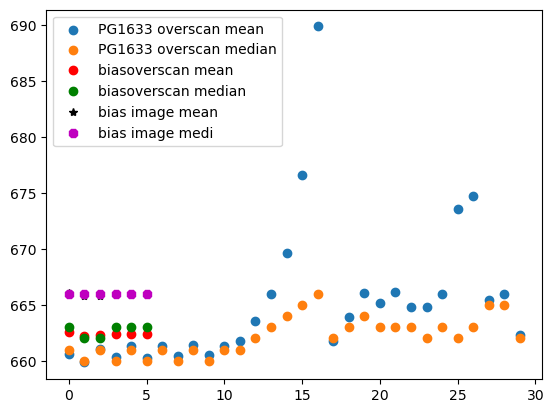

In [21]:
fig, ax = plt.subplots()
domain = range(len(PGovrsmn))
ax.scatter(domain, PGovrsmn, label='PG1633 overscan mean')
ax.scatter(domain, PGovrsmd, c='C1', label='PG1633 overscan median')
ax.plot(biasovrsmn, 'ro', label='biasoverscan mean')
ax.plot(biasovrsmd, 'go', label='biasoverscan median')
ax.plot(biasmean, 'k*', label='bias image mean')
ax.plot(biasmedi, 'm8', label='bias image medi')
ax.legend()
plt.show()

* overscan region has a lot of variation throughout the night - not good for \
use for calibrating images
* the image and overscan part of the bias seem to have pretty consistent levels\
but the uncovered part of the CCD (image) has higher levels. I guess this is \
due to the strange instrumental effects seen in the center column of the bias\
frames

# 6

* trimming one image for proof of concept of overscan

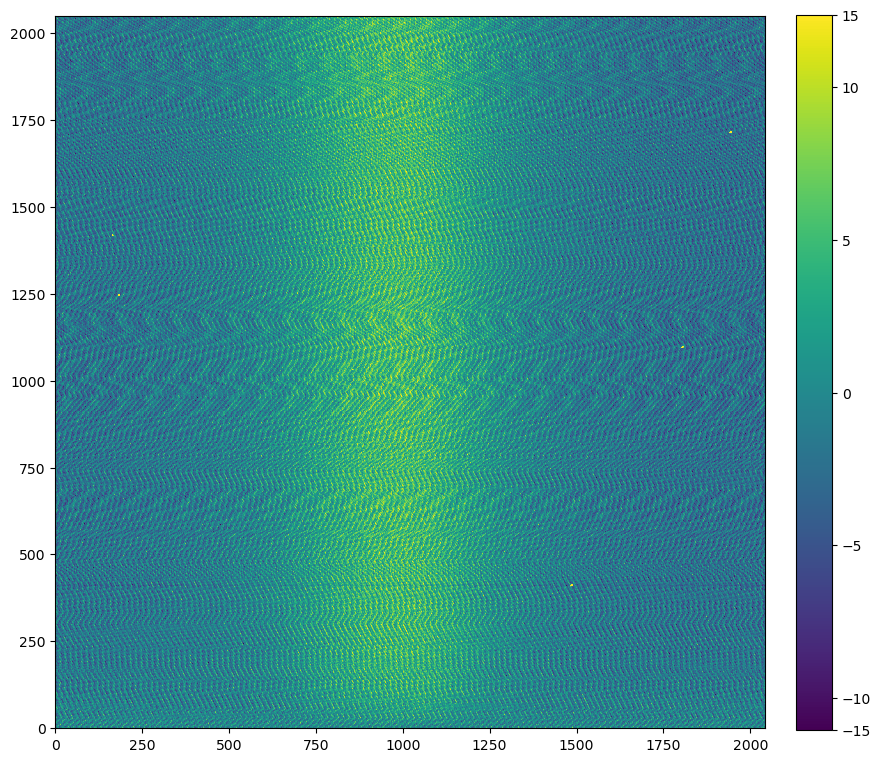

In [150]:
biasframes = imgs.files_filtered(imagetyp='Bias', include_path=True)


b1 = CCDData.read(biasframes[0], unit='adu')
b1_ovrscsub = ccdp.subtract_overscan(b1, overscan=b1[:, 55:2099])
b1_ovrsctrm = ccdp.trim_image(b1_ovrscsub[:, :2098])
b1_ovrsctrm = ccdp.trim_image(b1_ovrsctrm[:, 55:])
show_image(b1_ovrsctrm)

In [136]:
hdr['TRIMSEC']

'[55:2099, :]'

* modeling overscan regions 